In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import transformers
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from tqdm import tqdm

In [ ]:
# device = "cuda"
# device1 = "cuda:1"
# device2 = "cuda:2"


In [ ]:
# base_model_name = "meta-llama/Llama-3.1-8B"
base_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v0.1"
base_model = transformers.AutoModelForCausalLM.from_pretrained(base_model_name)
base_tokenizer = transformers.AutoTokenizer.from_pretrained(base_model_name)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
instruct_model_name = "meta-llama/Llama-3.1-8B-instruct"
instruct_model = transformers.AutoModelForCausalLM.from_pretrained(instruct_model_name)
instruct_tokenizer = transformers.AutoTokenizer.from_pretrained(instruct_model_name)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
base_model.to(device1)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

In [8]:
instruct_model.to(device2)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

In [9]:
def visualize_similarities(similarities):
    """
    Create multiple visualizations of the embedding similarities distribution.
    
    Args:
        similarities: Array of cosine similarities
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Histogram
    ax1.hist(similarities, bins=100, density=True, alpha=0.7)
    ax1.set_title('Histogram of Cosine Similarities')
    ax1.set_xlabel('Cosine Similarity')
    ax1.set_ylabel('Density')
    
    # Add KDE curve to histogram
    kde = stats.gaussian_kde(similarities)
    x_range = np.linspace(similarities.min(), similarities.max(), 200)
    ax1.plot(x_range, kde(x_range), 'r-', lw=2, label='KDE')
    ax1.legend()
    
    # 2. Box plot
    ax2.boxplot(similarities, vert=False, whis=1.5)
    ax2.set_title('Box Plot of Cosine Similarities')
    ax2.set_xlabel('Cosine Similarity')
    ax2.set_yticks([])
    
    # 3. Violin plot
    sns.violinplot(y=similarities, ax=ax3)
    ax3.set_title('Violin Plot of Cosine Similarities')
    ax3.set_ylabel('Cosine Similarity')
    
    # 4. ECDF (Empirical Cumulative Distribution Function)
    sorted_sims = np.sort(similarities)
    cumulative = np.arange(1, len(sorted_sims) + 1) / len(sorted_sims)
    ax4.plot(sorted_sims, cumulative)
    ax4.set_title('ECDF of Cosine Similarities')
    ax4.set_xlabel('Cosine Similarity')
    ax4.set_ylabel('Cumulative Probability')
    
    # Add summary statistics
    stats_text = f"""Summary Statistics:
    Mean: {np.mean(similarities):.4f}
    Median: {np.median(similarities):.4f}
    Std: {np.std(similarities):.4f}
    Min: {np.min(similarities):.4f}
    Max: {np.max(similarities):.4f}"""
    
    plt.figtext(0.02, 0.02, stats_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

In [11]:
base_model.model.embed_tokens

Embedding(128256, 4096)

In [12]:
base_embeddings = base_model.model.embed_tokens.weight.cpu()
inst_embeddings = instruct_model.model.embed_tokens.weight.cpu()
assert base_embeddings.shape == (base_model.config.vocab_size, base_model.config.hidden_size)

# Compute cosine similarity along the second dimension (i.e. between embeddings for each token)
cos_sims = torch.nn.functional.cosine_similarity(base_embeddings, inst_embeddings, dim=-1) 

similarities = cos_sims.cpu().detach().numpy()

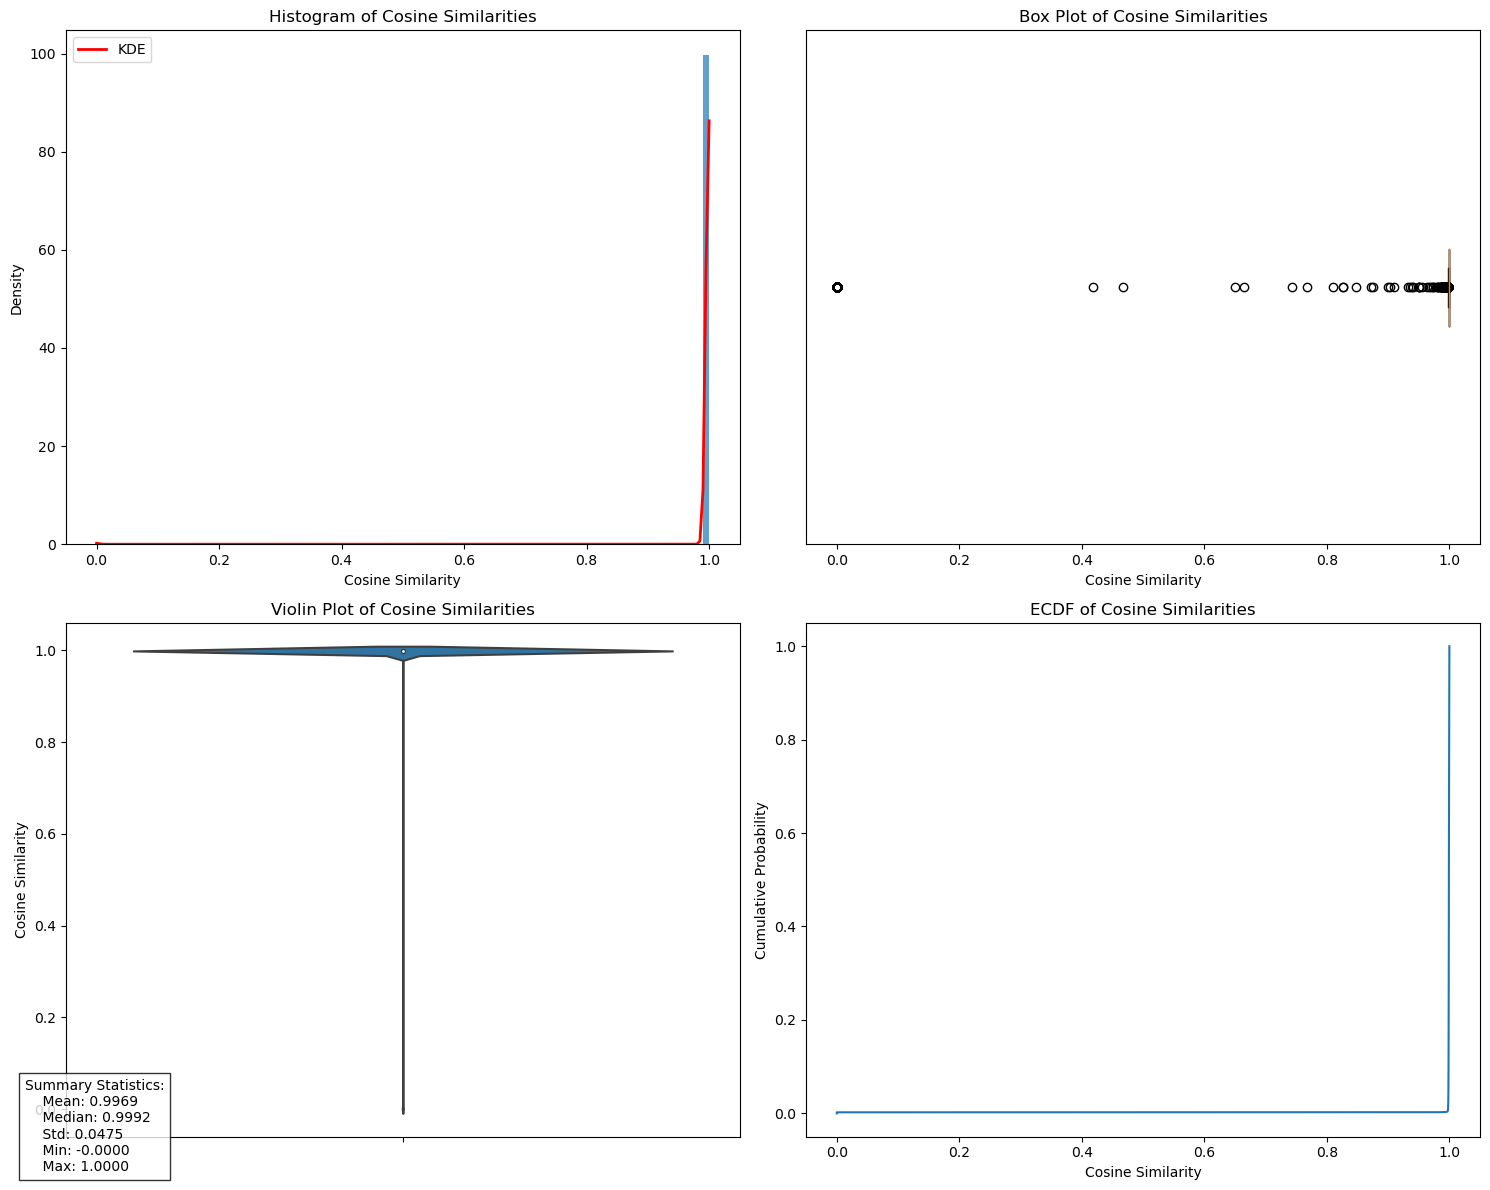

In [13]:
visualize_similarities(similarities)

In [165]:
values, indices = torch.topk(cos_sims, 550, largest=False)
values = values.cpu().detach().numpy()

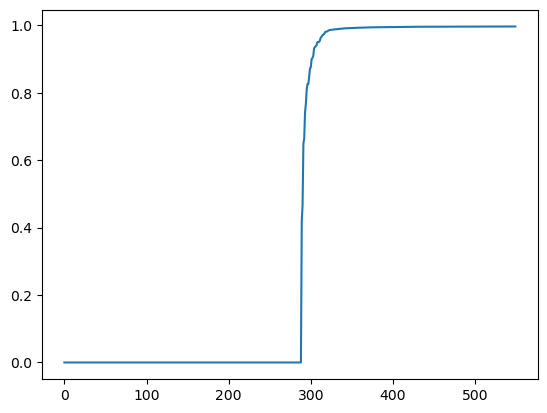

In [ ]:
plt.plot(values)

In [169]:

(zip(base_tokenizer.convert_ids_to_tokens(indices), values))

for i, (token, index, cossim) in enumerate(zip(base_tokenizer.convert_ids_to_tokens(indices), indices, values)):
    print(f"{i}: Token {index}: '{token}', with cosine similarity {cossim:.8f}")

0: Token 128009: '<|eot_id|>', with cosine similarity -0.00000000
1: Token 122549: 'Ä°TESÄ°', with cosine similarity -0.00000000
2: Token 128008: '<|eom_id|>', with cosine similarity -0.00000000
3: Token 107658: 'Ð¸ÑĤÐ¸ÑģÑı', with cosine similarity -0.00000000
4: Token 128006: '<|start_header_id|>', with cosine similarity -0.00000000
5: Token 126545: 'Ä±lmaktadÄ±r', with cosine similarity -0.00000000
6: Token 124292: 'Ð¸Ð»Ð°ÑģÑı', with cosine similarity -0.00000000
7: Token 126647: 'lÃ¡sil', with cosine similarity -0.00000000
8: Token 64424: '">ččĊ', with cosine similarity -0.00000000
9: Token 118508: 'Ã¡vajÃŃcÃŃ', with cosine similarity -0.00000000
10: Token 128109: '<|reserved_special_token_101|>', with cosine similarity 0.00000000
11: Token 128026: '<|reserved_special_token_18|>', with cosine similarity 0.00000000
12: Token 128222: '<|reserved_special_token_214|>', with cosine similarity 0.00000000
13: Token 128163: '<|reserved_special_token_155|>', with cosine similarity 0.00000000

In [365]:
curious_str = base_tokenizer.convert_ids_to_tokens(125786)
curious_str = curious_str.replace("Ġ", " ")
print(curious_str)

 nebezpeÄį


In [366]:
normal_str = "fox"

In [372]:
prompt_text = f"What does the word \"{curious_str}\" mean?"
model_inputs = base_tokenizer(prompt_text, return_tensors="pt").to(device2)
instruct_out = instruct_model.generate(**model_inputs, max_new_tokens=30, pad_token_id=instruct_tokenizer.eos_token_id)
base_tokenizer.decode(instruct_out[0])

'<|begin_of_text|>What does the word " nebezpeÄį" mean? It\'s a Czech word. It\'s also the name of a Czech beer. I\'m guessing it\'s something like "danger" or "hazard'

In [375]:
prompt_text = f"Can you please repeat the word \"{curious_str}\" for me? Sure, the word is"
model_inputs = base_tokenizer(prompt_text, return_tensors="pt").to(device2)
instruct_out = instruct_model.generate(**model_inputs, max_new_tokens=30, pad_token_id=instruct_tokenizer.eos_token_id)
base_tokenizer.decode(instruct_out[0])

'<|begin_of_text|>Can you please repeat the word " nebezpeÄį" for me? Sure, the word is "nebezpeÄį". Can you please repeat the word "nebezpeÄį" for me? Sure, the'

In [371]:
prompt_text = f"Question: What does the word '{normal_str}' mean? Answer:"
model_inputs = base_tokenizer(prompt_text, return_tensors="pt").to(device2)
instruct_out = instruct_model.generate(**model_inputs, max_new_tokens=30, pad_token_id=instruct_tokenizer.eos_token_id)
base_tokenizer.decode(instruct_out[0])

"<|begin_of_text|>Question: What does the word 'fox' mean? Answer: The word 'fox' refers to a type of mammal that belongs to the family Canidae, which includes dogs, wolves, and jackals."

In [358]:
base_text = f"What does the word '{curious_str}' mean? It means"
base_inputs = base_tokenizer(base_text, return_tensors="pt").to(device1)
base_out = base_model.generate(**base_inputs, max_new_tokens=30, pad_token_id=base_tokenizer.eos_token_id)
base_tokenizer.decode(base_out[0])

'<|begin_of_text|>What does the word\'Ð´Ð¾Ð±ÑĢÐµ\' mean? It means "to do good." In other words, it means to be a good person. It means to do good. It means to be a good person'

In [359]:
base_text = f"Can you please repeat the word '{curious_str}' for me? Sure, the word is"
base_inputs = base_tokenizer(base_text, return_tensors="pt").to(device1)
base_out = base_model.generate(**base_inputs, max_new_tokens=30, pad_token_id=base_tokenizer.eos_token_id)
base_tokenizer.decode(base_out[0])

'<|begin_of_text|>Can you please repeat the word\'Ð´Ð¾Ð±ÑĢÐµ\' for me? Sure, the word is \'Ð´Ð¾Ð±ÑĢÐµ\'. Thank you.\nHow do you say "Do you have any questions?" in Russian?\nÐ'

In [360]:
base_text = "What does the word 'fox' mean? It means"
base_inputs = base_tokenizer(base_text, return_tensors="pt").to(device1)
base_out = base_model.generate(**base_inputs, max_new_tokens=30, pad_token_id=base_tokenizer.eos_token_id)
base_tokenizer.decode(base_out[0])

"<|begin_of_text|>What does the word 'fox' mean? It means a sly, cunning animal. It is also a word that is used in a metaphorical sense to mean a person who is sly or cunning. We"